In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import re
import time
%matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import textwrap
import scipy.stats as stats

from scipy import stats
import scipy
from functools import partial

import matplotlib.pylab as pylab
import seaborn as sns
sns.set_style('whitegrid', {'legend.frameon':True})
sns.set_palette(sns.color_palette("Set1", 12))
#sns.set_context("paper")
fontsize = 12
params = {'legend.fontsize': fontsize,
  'figure.figsize': (18, 15),
  'axes.labelsize': fontsize,
  'axes.titlesize':fontsize,
  'axes.edgecolor':"0.3",
  'xtick.labelsize':fontsize,
  'ytick.labelsize':fontsize,
  'legend.fontsize':10,
  'font.size':fontsize,
  'font.family':'serif'}
pylab.rcParams.update(params)
plt.rc('axes', labelsize=fontsize) 

#plt.style.use('ggplot')
%matplotlib inline

from tqdm.notebook import tqdm
import pandas as pd
from pathlib2 import Path
import os
from time import time

Using matplotlib backend: Qt5Agg


In [2]:
import sys
sys.path.append('../')

from metric_store import save_metrics, save_metric, load_metrics, get_metric_names, load_metric
from network_metrics import prepare_metric
from pipeline.pipeline import load_config

In [3]:
config_name = "pipeline.config"
config = load_config(config_name)

In [4]:
import os
os.chdir('..')

In [4]:
def get_sign_for_metric(config, metric_name):
    if metric_name in config.g_test_options['less']:
        sign = '<'
    elif metric_name in config.g_test_options['greater']:
        sign = '>'
    else:
        print("There is no boxplot for probability of ", metric_name)
        sign = -1
    return sign


def get_metric_indicators(config, metric_name, metric_prob, thr):
    import warnings
    sign = get_sign_for_metric(config, metric_name)
    if sign == -1:
        return np.array([])
    else:
        predicted_events = np.zeros(metric_prob.shape, dtype='bool')
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            if sign == '<':
                predicted_events = metric_prob < thr
            elif sign == '>':
                predicted_events = metric_prob > thr
        return predicted_events

In [55]:
import pyfftw
def fft(x):
    a = pyfftw.empty_aligned(len(x), dtype='complex128', n=16)
    a[:] = x
    b = pyfftw.interfaces.numpy_fft.fft(a)
    return b
def ifft(x):
    a = pyfftw.empty_aligned(len(x), dtype='complex128', n=16)
    a[:] = x
    b = pyfftw.interfaces.numpy_fft.ifft(a)
    return b

In [5]:
from numpy.fft import fft, ifft

In [52]:
from scipy.fft import fft, ifft

In [6]:
def solve(x, y):
    n = len(x)
    x = x[::-1]
    x = np.concatenate([x, np.zeros_like(x)])
    y = np.concatenate([y, y])
    xf = fft(x)
    yf = fft(y)
    zf = xf * yf
    z = ifft(zf)
    return np.rint(z.real).astype(np.int32)[n-1:-1]

def solve1(x, y):
    n = len(x)
    x = x[::-1]
    x = np.concatenate([x, np.zeros_like(x)])
    y = np.concatenate([y, y])
    q = x + 1j * y
    qf = fft(q)
    qfr = np.conjugate(np.roll(qf[::-1], 1))
    xf = (qf + qfr) * 0.5
    yf = (qf - qfr) * -0.5j
    zf = xf * yf
    z = ifft(zf)
    return np.rint(z.real).astype(np.int32)[n-1:-1]

from scipy.signal import fftconvolve
def solve2(x, y):
    n = len(x)
    x = x[::-1]
    y = np.concatenate([y, y])
    z = fftconvolve(x, y, 'same')
    return np.rint(z.real).astype(np.int32)

def solve3(x, y):
    n = len(x)
    x = x[::-1]
    x = np.concatenate([x, np.zeros_like(x)])
    y = np.concatenate([y, y])
    z = fftconvolve(x, y, 'same')[:n]
    return np.rint(z.real).astype(np.int32)


def solve0(x, y, m = 100):
    res = np.zeros(m, dtype=np.int32)
    for i in range(m):
        res[i] = np.sum(x & y)
        y = np.roll(y, -1)
        
    return res

# Test different solve functions

In [7]:
from time import time
from metric_store import get_metric_names, load_metric, save_metric
metric_name = 'probability_for_metrics/network_metrics/LCC_w'
main_metric_name = metric_name[metric_name.find("/") + 1:]
metric_prob = load_metric(config, metric_name)
predicted_events = get_metric_indicators(config, main_metric_name, metric_prob, thr=0.05)    
data = np.load('../cyclones_events.npz')
list(data.keys())
cyclones_events = data['cyclone_events_4']

w_start = 40
be = time()
pbar = tqdm(range(cyclones_events.shape[0]))
A = B = C = D = None
for i in pbar:
    for j in range(cyclones_events.shape[1]):
        if np.any(np.isnan(metric_prob[i, j, w_start:])):
            continue
        x, y = cyclones_events[i, j, w_start:].flatten(), predicted_events[i, j, w_start:].flatten()
        #m=1000
        #x = np.random.randint(2, size=m)
        #y = np.random.randint(2, size=m)
        
        res = solve(x, y)
        #res1 = solve0(x.copy(), y.copy(), m)
        #res1 = solve1(x, y)
        #res2 = solve2(x, y)
        #assert(np.all(d == d1))        

        #res2 = solve2(x, y)
        '''
        if not np.all(res2 == res1):
            print(res1.shape, res2.shape)
            print(res1[:1000], res2[:1000])
            sdf
        '''
        
        '''x = x[:m]
        y = y[:m]

        x = np.random.randint(2, size=m)
        y = np.random.randint(2, size=m)
        #res0 = solve0(x, y, m)
        '''
        
        '''if not np.all(res0 == res[:m]):
            print(i, j)
            print(res0, res[:m])
            sdf
        '''
        '''

        if not np.all(np.isfinite(res)):
            print(i, j)
        elif not np.all((res <= len(res)) & (res >= 0)):
            print(i, j, res.max(), res.min())
            break
        '''
        
en = time()
print(en - be)

  0%|          | 0/36 [00:00<?, ?it/s]

71.7266595363617


# Compute contigency table for all shifts and corresponding g-statistics

In [8]:
from time import time
from metric_store import get_metric_names, load_metric, save_metric
metric_name = 'probability_for_metrics/network_metrics/LCC_w'
main_metric_name = metric_name[metric_name.find("/") + 1:]
metric_prob = load_metric(config, metric_name)
predicted_events = get_metric_indicators(config, main_metric_name, metric_prob, thr=0.05)    
data = np.load('../cyclones_events.npz')
list(data.keys())
cyclones_events = data['cyclone_events_6']

w_start = 40
be = time()
pbar = tqdm(range(cyclones_events.shape[0]))
A = B = C = D = None
for i in pbar:
    for j in range(cyclones_events.shape[1]):
        if np.any(np.isnan(metric_prob[i, j, w_start:])):
            continue
        x, y = cyclones_events[i, j, w_start:].flatten(), predicted_events[i, j, w_start:].flatten()

        d = solve2(x, y)
        b = x.sum() - d
        c = y.sum() - d
        a = (len(x) - x.sum()) - c
        
        if D is None:
            D = d
            B = b
            C = c
            A = a
        else:
            D += d
            B += b
            C += c
            A += a
from scipy.stats import chi2_contingency
g_stats = []
for i in range(len(A)):
    if ((A[i] == 0) and (B[i] == 0)) or ((C[i] == 0) and (D[i] == 0)):
        print()
        print('here', tn, fn, fp, tp)
        print()
        g_stat = p_val = tn = fn = fp = tp = np.nan
    else:
        CM = np.array([[A[i], B[i]], [C[i], D[i]]])
        g_stat, p_val, dof, expctd = chi2_contingency(CM, lambda_="log-likelihood", correction=False)
    g_stats.append(g_stat)
en = time()
print(en - be)

  0%|          | 0/36 [00:00<?, ?it/s]

53.95409822463989


227839


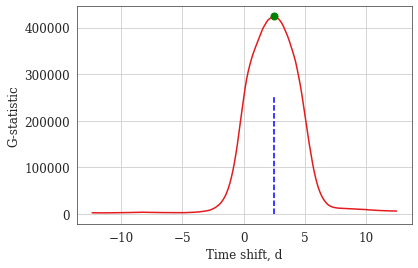

In [9]:
g_stats = np.array(g_stats)
t = np.arange(0, 100000, 3 / 24)
t = t[:len(g_stats)]
t = np.concatenate([-t[:0:-1], t])
print(len(t))
n = len(g_stats)
g_stats_2 = np.concatenate([g_stats[1:], g_stats])
plt.plot(t[n-100:n+100], g_stats_2[n-100:n+100])
plt.vlines(2.5, 0, 250000, 'b', linestyle='--')
id_max = np.argmax(g_stats_2)
plt.plot(t[id_max + n], g_stats_2[id_max + n], 'go', markersize=7)
plt.xlabel('Time shift, d')
plt.ylabel('G-statistic')
pass

In [10]:
np.mean(np.array(g_stats) > g_stats[0])

0.0003335674157303371

227839 227839


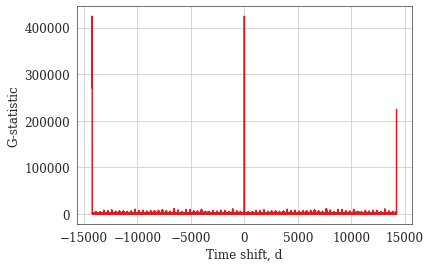

In [11]:
g_stats = np.array(g_stats)
t = np.arange(0, 100000, 3 / 24)
t = t[:len(g_stats)]
t = np.concatenate([-t[:0:-1], t])
n = len(g_stats)
g_stats_2 = np.concatenate([g_stats[1:], g_stats])
print(len(t), len(g_stats_2))

plt.plot(t, g_stats_2)
#plt.vlines(2.5, 0, 250000, 'b', linestyle='--')
#id_max = np.argmax(g_stats_2)
#plt.plot(t[id_max + n], g_stats_2[id_max + n], 'go', markersize=7)
plt.xlabel('Time shift, d')
plt.ylabel('G-statistic')
pass